# 빅데이터 분석을 위한 실시간 로지스틱 회귀모형에 관현 연구
## : 베이지안 접근법을 중심으로

---

## 1. 배경

## 2. 해싱을 이용한 가변수 코딩(Feature Hashing)

## 3. 온라인 최적화 알고리즘

### 3.1. 확률적 경사 하강법(Stochastic Gradient Descent)

> 최적화(optimization) 알고리즘의 하나인 경사하강법(Gradient descent)에서는 전체 샘플 데이터를 스캔 할 때마다 회귀 계수 추정치를 갱신해 나간다. 비용함수(cost function)를 $J(w) = \frac{1}{2} \sum_{i}(target^{(i)} - output^{(i)})^{2}$ 라 할때 길이가 j인 계수 벡터(weight vector) $w_i$를 $w_{i+1}=w_{i}+\Delta w$로 갱신하는 매 반복에서 $j$개의 모수 추정치($w$)를 얼마만큼 줄일지 혹은 늘릴지 $\Delta w$ 값을 결정해야 한다. 여기에서 $\Delta w$는 아래와 같다.
\begin{eqnarray}
\Delta w_{j} 	&=& -\alpha \frac{\delta J}{\delta w_{j}} \\
							&=& -\alpha \sum_{i}(target^{(i)} - output^{(i)})(-x^{(i)_{j}}) \\
							&=& \alpha \sum_{i}(target^{(i)} - output^{(i)})(x^{(i)_{j}})
\end{eqnarray}
즉 비용함수(cost function)의 경사도가 크면 그만큼 많이 $w$값을 수정하게 되는데, 학습 계수(learning rate, step size) $\alpha$에 비례하여 수정치가 결정된다.

> 경사하강법에서는 한번 $w$값을 수정하기 위하여 전체 샘플 데이터를 스캔하게 된다. 그런데 이런 방식은 샘플의 수가 많은 경우 
비용함수 $J(w)$를 최소로 하는 $w$값을 찾기 까지 그 처리 시간이 길어 지게 된다. 모수에 대한 학습(learning)이나 추론(inference)를 진행할 때 데이터의 크기가 작거나 데이터의 수집으로부터 예측까지 시간적 여유가 있을 경우 데이터 전체를 한꺼번에 활용하는 일괄 처리(batch processing) 방식을 사용한다. 반면 데이터를 한꺼번에 처리하기에 그 크기가 지나치게 크거나 스트리밍(streaming)으로 유입되는 데이터에 대해서 실시간으로 예측을 처리해야 하는 경우 온라인 학습(online learning)을 사용해야 할 필요성이 있다.

> 이처럼 매 갱신에서 전체 샘플 데이터를 사용하는 대신 샘플 하나 혹은 일부분만을 사용하여 $w$ 값을 갱신해 가는 경사하강법을 확률적 경사 하강법(Stochastic Gradient Descent, Online Gradient Descent)이라 하며, 확률적 이라는 단어에서 알 수 있듯이 $J(w)$를 최소로 하는 $w$값을 확률적 근사방법으로 찾아가는 것이다. 하나의 샘플만을 이용해 $w$의 갱신 방향과 크기를 결정하기 때문에 경사하강법과는 달리 $J(w)$값이 커지는 경우도 있으나 샘플 수가 충분할 경우 $J(w)$의 전역 최소값으로 수렴하는 $w$를 찾을 수 있는 것으로 알려져 있다.

> - 본 연구에서는 전체 파라미터 벡터에 동일한 step size 초기값을 설정하고, iteration이 증가하면서 각 hashed-feature가 등장하는 횟수로 step size를 나눈다.  
> - 즉 특정 hashed-feature가 많이 등장할 수록 해당 회귀 모수에 대한 step-size가 감소하게 되고, 자주 등장하지 않는 hashed-feature의 경우 비교적 큰 step-size를 갖게 된다.

###### [알고리즘]

In [2]:
# simplified version of SGD
c_fi = fi_titanic

D = 2 ** 20
alpha = 0.92000539999999997 # initial value for setp size alpha
w = [0.] * D  # feature vector
n = np.array([0.] * (D))

f = open(c_fi.file_path)
for t, row in enumerate(DictReader(f, fieldnames=c_fi.l_header_names, delimiter=c_fi.seperator)):  # for titanic(comma seperated)
    if t == 0:
        continue
    del row['PassengerId']
    
    y = 1. if row[c_fi.ylab] == '1' else 0.
    del row[c_fi.ylab]
    
    x = get_x_mmh3(row, D)
    p = get_p(x, w)
    w, n = update_w_withn(w, n, x, p, y, alpha)
f.close()

NameError: name 'fi_titanic' is not defined

In [3]:
def update_w_withn(w, n, x, p, y, alpha):
    for i in x:
        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
        n[i] += 1.
    return w, n

### 3.2. 추정된 밀도 필터링(Assumed Density Filtering)

###### 추정된 밀도 필터링(Assumed-density filtering, ADF) 이란?

> 추정된 밀도 필터링(Assumed-density filtering, ADF)는 베이지안 네트워크 혹은 여타의 통계 모형에서 사후분포를 근사적으로 계산하는 방법으로서 통계학에는 Lauritzen, 1992이 제안. 분야에 따라 달리 불림
 
 > - 추정된 밀도 필터링(Assumed-density filtering)  
 > - 온라인 베이지안 학습(On-line Bayesian learning)  
 > - 적률 대응(Moment matching)  
 > - 약한 주변화(Weak marginalization)  

>  ADF에서는 사후분포를 가우시안과 같은 특정 분포로 근사하는 방법으로서 예측-갱신-투영(predict-update-project)과정을 반복한다. 
 
> - 예측(predict): 모수 $\theta$에 대한 $t-1$ 시점의 사전분포, $q_{t-1}(\theta_{t-1})$와 $t$시점의 관측치를 이용하여 이후 시점 $t$에서의 $\theta$에 대한 사후예측분포, $q_{t|t-1}(\theta_{t})$를 구함
> - 갱신(update): 앞서 구한 사전분포와 사후예측분포를 이용하여 $\theta$에 대한 사후분포, $\hat{p}(\theta_t)$를 구함 
> - 투영(project): 마지막으로 이 사후 분포가 다루기 쉬운 형태가 아닌 경우가 빈번하기 때문에 다루기 쉬운 분포로 투영(project)ㅡ

> - 근사 사전분포: 
$$q_{t-1}(\theta_{t-1}) \approx p(\theta_{t-1}|y_{1:t-1})$$
<br>
- 1단계 사후예측분포: 
$$q_{t|t-1}(\theta_t) = \int p(\theta_t | \theta_{t-1}) q_{t-1}(\theta_{t-1}) d\theta_{t-1}$$
<br>
- 사후분포:
$$\hat{p}(\theta_t) = \frac{1}{Z_t}p(y_t | \theta_t)q_{t|t-1}(\theta_t)$$
<br>
- 정규화 상수(normalizing constant):
$$Z_t = \int p(y_t | \theta_{t-1})q_{t|t-1}(\theta_{t})d\theta_{t}$$
<br>
- 근사 사후분포:
$$q(\theta_t) = \arg\min_{q \in Q} \mathrm{KL}(\hat{p}(\theta_t || q(\theta_t)) $$

###### 지수족에서의 추정된 밀도 필터링(Assumed-density filtering, ADF) 

> 투영하려는 분포 $q$가 지수족에 속할 경우 단순히 적률 대응(moment matching)만으로 $q(\theta_t)$를 구할수 있다. 따라서 일반화 선형모형에 적률 대응을 적용.

> 편의를 위해 설명변수와 회귀계수의 선형식(systematic component)을 $s_t=\theta_t^T x_t$라 하고, 만약 $\theta_t$에 대한 1단계 사후예측분포, $q_{t|t-1}(\theta_t)$가$\prod_i N(\theta_{t,i};\mu_{t|t-1,i},\sigma^2_{t|t-1,i})$라면 $s_t$의 사후 예측분포, $q_{t|t-1}(s_t)$ 는 아래와 같다.

> \begin{eqnarray}
   q_{t|t-1}(s_{t}) &\equiv& N(s_t;m_{t|t-1}, {v}_{t|t-1})
\\ m_{t|t-1} &=& \sum^N_{i=1}x_{t,i}\mu_{t|t-1,i}
\\ {v}_{t|t-1} &=& \sum^N_{i=1}x^2_{t,i}{\sigma}^2_{t|t-1,i}
\end{eqnarray}

> 이때 $s_t$의 사후분포, $q_t(s_t)$는 아래와 같다.

> \begin{eqnarray}
 q_t(s_t) &\equiv& N(s_t; m_t, v_t)
 \\ m_t &=& \int s_t \frac{1}{z_t} f(y_t|s_t) q_{t|t-1}(s_t)ds_t
 \\ v_t &=& \int s^2_t \frac{1}{z_t} f(y_t|s_t) q_{t|t-1}(s_t) ds_t - m_t^2  
\\ z_t &=& \int f(y_t|s_t) q_{t|t-1}(s_t)ds_t
\\ f(y_t|s_t) &\equiv& Ber(y_t;\pi = sigmoid(s_t))
\\ & =& \pi^{y_t} (1-\pi)^{(1-y_t)}, \quad y_t \in \{0,1\}
\end{eqnarray}

> 가우시안 구적법(Gaussian quadrature)을 이용해 위 적분식 근사
$$\int^b_a W(x)f(x)dx \approx \sum^N_{j=1}w_j f(x_j)$$
$$\chi=\chi'\sqrt{2}\sigma_{s_t}+\mu_{s_t}$$ 
$$\omega_i = \frac{\omega'}{\sqrt{\pi}}$$

> \begin{eqnarray}
q_t(s_t) &=& N(s_t; \tilde{m}_t, \tilde{v}_t)
\\ \tilde{m}_t &=& \frac{1}{\tilde{z}_t} \sum_i \chi_i f(y_t; \chi_i ) \omega_i
\\ \tilde{v}_t &=& \frac{1}{\tilde{z}_t} \sum_i \chi^2_i f(y_t; \chi_i ) \omega_i - \tilde{m}^2_t
\\ \tilde{z}_t &=& \sum_i f(y_t; \chi_i ) \omega_i
\end{eqnarray}

###### 알고리즘

In [4]:
init_v = 0.52007399999999993 # best for titanic

theta_t_m = np.array([0.] * (D)) # mean of thetas at t
theta_t_v = np.array([init_v] * (D)) # variance of thetas at t
n = np.array([0.] * D)

f = open(c_fi.file_path)
for t, row in enumerate(DictReader(f, fieldnames=c_fi.l_header_names, delimiter=c_fi.seperator)):

    if t == 0:
        continue
    del row['PassengerId']
    
    y = 1. if row[c_fi.ylab] == '1' else 0.
    del row[c_fi.ylab]

    x = get_x_mmh3(row, D)

    # Predictive distribution for s_t ~ N(s_t_m_old, s_t_v_old)
    s_t_m_old = sum(theta_t_m[x])
    s_t_v_old = sum(theta_t_v[x])

    # Posterior distribution for s_t
    s_t_m, s_t_v = get_s_t_new(y, s_t_m_old, s_t_v_old)

    # Changes in s_t
    delta_m = s_t_m - s_t_m_old
    delta_v = s_t_v - s_t_v_old

    # Updating theta
    update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, t, n)

    #p = get_p_cat(x, theta_t_m)

f.close()

NameError: name 'np' is not defined

In [5]:
# s_t_m_old and s_t_v_old must be numpy ndarray
def get_s_t_new(y, s_t_m_old, s_t_v_old):

    wi = wwi / np.sqrt(np.pi)
    xi = xxi * np.sqrt(2) * np.sqrt(s_t_v_old) + s_t_m_old
    
    fw = 0.
    if(y==1):
        fw = (1. / (1. + np.exp(-xi))) * wi
    else:
        fw = ((np.exp(-xi)) / (1. + np.exp(-xi))) * wi

    z_t = sum(fw)
    s_t_m_new = 1. / z_t * sum(xi * fw)
    s_t_v_new = 1. / z_t * sum((xi**2) * fw) - s_t_m_new**2
        
    return (s_t_m_new, s_t_v_new)

In [6]:
def update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, n_iter, n):
    a_i = get_a_i_cat(x, theta_t_v)
    theta_t_m[x] += (a_i * delta_m)
    theta_t_v[x] += ((a_i**2) * delta_v)
    n[x] += 1.

In [7]:
# theta_t_v must be numpy ndarray
def get_a_i_cat(x, theta_t_v):
    return theta_t_v[x] / sum(theta_t_v[x])

## 4. 실험

### 4.1. 실험(타이타닉 데이터)

###### 개요

> - 소규모 데이터를 이용한 실험을 위해 891건의 타이타닉 생존자 데이터를 이용  
> - 데이터는 생존여부(0, 1)를 나타내는 'Survived'와 탑승자의 특성을 나타내는 8가지 변수로 구성됨.
> - 초기 800건을 훈련 데이터, 나머지 91건을 테스트 데이터로 사용

###### 최적 초기값

> SGD는 step size의 초기값($\alpha_{init}$)에, ADF는 회귀 계수 분포의 초기 분산값($V_{init}$)에 큰 영향을 받음.  
> 주어진 데이터에 최적인 $\alpha_{init}$과 $V_{init}$를 찾기 위해 각 값을 변화시키면서, 훈련 데이터와 테스트 데이터에 대한 log-loss를 관찰함

> $logloss = -\frac{1}{N}\sum_{i=1}^N {(y_i\log(p_i) + (1 - y_i)\log(1 - p_i))}$

<center>**Stochastic Gadient Descent**</center>

 ![Local image](./images/best_param_sgd_T.png "Tooltip for local image")

|          | Index     | $\alpha$          |  log-loss |
|----------|:-------:|:--------------:|
| AUC      | 11 | 0.11000779999999999 | 0.46879230769345764

>  테스트 데이터에 최소 log-loss를 갖는 $\alpha$값은 0.11000779999999999

<center>**Assumed Density Filtering**</center>

 ![Local image](./images/best_param_adf_T.png "Tooltip for local image")

|          | Index     | $\alpha$          |  log-loss |
|----------|:-------:|:--------------:|
| AUC      | 13 | 0.52007399999999993 | 0.39539652671035114

> 테스트 데이터에 최소 log-loss를 갖는 분산값은 0.52007399999999993

###### 훈련 데이터 크기에 따른 log-loss 비교

> 16건의 훈련 데이터를 더 사용할 때마다 그때의 회귀 계수 벡터를 이용하여 91건의 테스트 데이터에 대한 log-loss 추이를 두 방법론(SGD, ADF)에 대해 비교한다.

 ![Local image](./images/step_vali_comparison_T.png "Tooltip for local image")

> 전반적으로 ADF에 비해 SGD의 log-loss가 낮음.

 ![Local image](./images/step_vali_roc_T.png "Tooltip for local image")

|          | SGD     | ADF          |
|----------|:-------:|:--------------:|
| AUC      |0.90041279669762642 | 0.88802889576883381  |

### 4.2. 실험(온라인 광고 데이터)

###### 개요

> Criteo에서 'Kaggle 대회'를 위해 공개한 4천 5백만건 상당의 온라인 광고 데이터를 사용하였다. 데이터는 웹사이트 방문자가 해당 광고를 클릭 했으냐 혹은 하지 않았느냐를 나타내는 이항 반응변수 Label과 39개의 설명변수로 구성되어 있다. 그리고 각 설명변수는 범주형으로서 범주는 500개 이상으로 실제 데이터의 경우 훈련 데이터에 없던 범주가 새롭게 등장 할 수도 있는 특성을 갖는다. 이러한 데이터를 일괄처리(batch) 방식으로 처리한다면 대략 $19,500 \times 45,000,000$ 크기의 매트릭스 연산을 수행해야 한다.

###### 최적 초기값

<center>**Stochastic Gadient Descent**</center>

 ![Local image](./images/best_param_sgd_C.png "Tooltip for local image")

<center>**Assumed Density Filtering**</center>

 ![Local image](./images/best_param_adf_C.png "Tooltip for local image")

###### 훈련 데이터 크기에 따른 log-loss 비교

 ![Local image](./images/step_vali_comparison_C.png "Tooltip for local image")

 ![Local image](./images/step_vali_roc_C.png "Tooltip for local image")

|          | SGD     | ADF          |
|----------|:-------:|:--------------:|
| AUC      | 0.75874125874125875 | 0.75699300699300698 |

## 5. 맺음말

# [부록 - 구현]

### Simulation SGD for titanic data

In [8]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt
import numpy as np
import mmh3
import time
from spooky import hash128, hash64, hash32

from sklearn.metrics import roc_curve, auc
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

###### Parameters

In [9]:
D = 2 ** 20
rand_seed = 1004

num_poly = 10
xxi, wwi = np.polynomial.hermite.hermgauss(num_poly)

In [10]:
class DataSize:
    def __init__(self
                 , num_metric_check_point
                 , num_status_check_point
                 , num_train_data_start
                 , num_train_data_size
                 , num_test_data_start
                 , num_test_data_size):
        
        self.num_metric_check_point = num_metric_check_point
        self.num_status_check_point = num_status_check_point
        
        self.num_train_data_start = num_train_data_start
        self.num_train_data_end = self.num_train_data_start + num_train_data_size - 1 # fixed
        
        self.num_test_data_start = num_test_data_start
        self.num_test_data_end = self.num_test_data_start + num_test_data_size - 1 # fixed
        
    def display(self):
        print("num_metric_check_point: %s" %(self.num_metric_check_point))
        print("num_status_check_point: %s" %(self.num_status_check_point))
        print("num_train_data_start  : %s" %(self.num_train_data_start))
        print("num_train_data_end    : %s" %(self.num_train_data_end))
        print("num_train_data_size   : %s" %(self.num_train_data_end - self.num_train_data_start + 1))
        print("num_test_data_start   : %s" %(self.num_test_data_start))
        print("num_test_data_end     : %s" %(self.num_test_data_end))
        print("num_test_data_size    : %s" %(self.num_test_data_end - self.num_test_data_start + 1))

In [11]:
class FileInfo:
    def __init__(self
                , _file_path
                , _f_having_header
                , _l_header_names
                , _seperator
                , _l_skip_columns
                , _ylab):
        self.file_path = _file_path
        self.f_having_header = _f_having_header
        self.l_header_names = _l_header_names
        self.seperator = _seperator
        self.l_skip_columns = _l_skip_columns
        self.ylab = _ylab
    

In [12]:
fi_titanic = FileInfo(
                r'C:/My/Playground/Git/2016_Thesis/100_Simulation/data/train.csv' # _file_path
                , True # _f_having_header
                , ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex'
                   , 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin' , 'Embarked'] # _l_header_names
                , ',' # _seperator
                , ['PassengerId']# _l_skip_columns
                , 'Survived'# _ylab
                )

fi_criteo = FileInfo(
                r'C:\Temp\dac.tar\train.txt' # _file_path
                , False # _f_having_header
                , ['Label'] + [ 'I' + str(i) for i in list(range(1,14))] + [ 'C' + str(i) for i in list(range(1,27))] # _l_header_names
                , '\t' # _seperator
                , []# _l_skip_columns
                , 'Label'# _ylab
                )

###### Functions

In [13]:
# csv_row must be dict
def get_x_mmh3(csv_row, D):
    x = [0]
    for key, value in csv_row.items():
        index = mmh3.hash128(str(key) + str(value), seed=rand_seed, x64arch=True) % D
        x.append(index)
    return x

In [14]:
# csv_row must be dict
def get_x_spooky(csv_row, D):
    x = [0]
    for key, value in csv_row.items():
        index = hash32(str(key) + str(value)) % D
        x.append(index)
    return x

In [15]:
def get_p(x, w):
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid

In [16]:
# w must be numpy ndarray
def get_p_cat(x, w):
    wTx = sum(w[x])
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid

In [17]:
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)

In [18]:
def get_validation_metrics(c_fi,start, end, wlen, w, f_debug):
    
    log_loss = 0.
    arr_y = []
    arr_p = []
        
    f = open(c_fi.file_path)
    for t, row in enumerate(DictReader(f, fieldnames=c_fi.l_header_names, delimiter=c_fi.seperator)):
        if t == 0:
            continue # just for titanic
        
        if t < start: # fixed
            continue;

        y = 1. if row[c_fi.ylab] == '1' else 0.
        del row[c_fi.ylab]
        arr_y.append(y)
        
        if(len(c_fi.l_skip_columns) > 0):
            for i in range(len(c_fi.l_skip_columns)):
                del row[(c_fi.l_skip_columns)[i]] # for titanic
        
        x = get_x_mmh3(row, wlen)
        
        p = 0
        if(isinstance(w, list)):
            p = get_p(x, w)
        else:
            p = get_p_cat(x, w)
        arr_p.append(p)
        
        log_loss += logloss(p, y)   
        
        if f_debug:
            if t >= 1:  # fixed
                print(' [get_validation_metrics] %s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss/t))

        # End of ...
        if t >= end: # fixed
            break;
    
    f.close()
    
    return(log_loss, arr_y, arr_p)

#fn = ['Label'] + [ 'I' + str(i) for i in list(range(1,14))] + [ 'C' + str(i) for i in list(range(1,27))]
#get_validation_metrics(train, fn, '\t', 'Label', num_test_data_start, num_test_data_end, D, w)

In [19]:
def plot_log_loss(arr_log_loss):
    plt.figure(num=None, figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
    x = range(len(arr_log_loss))
    plt.plot(x, arr_log_loss, label='log_loss', marker='o')

# SGD

###### Functions

In [20]:
def update_w_withn(w, n, x, p, y, alpha):
    for i in x:
        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
        n[i] += 1.
    return w, n

In [21]:
def update_w(w, n, x, p, y, alpha):
    for i in x:
        w[i] -= (p - y) * alpha
        n[i] += 1.
    return w, n

###### Training function

In [22]:
def sgd_training(alpha, D, f_debug, f_step_validation, f_validation, c_ds, c_fi):
    w = [0.] * D  # weights
    n = np.array([0.] * (D))

    start_time = time.time()

    log_loss_sgd_training = 0.
    arr_log_loss_sgd_test = []
    
    f = open(c_fi.file_path)
    fn = c_fi.l_header_names
    
    for t, row in enumerate(DictReader(f, fieldnames=fn, delimiter=c_fi.seperator)):  # for titanic(comma seperated)
        
        if len(c_fi.l_skip_columns) > 0 :
            for i in range(len(c_fi.l_skip_columns)):
                del row[(c_fi.l_skip_columns)[i]] # for titanic
        
        if t == 0 & c_fi.f_having_header:
            continue
        
        if t < c_ds.num_train_data_start:
            continue
        # Start of ...
        
        y = 1. if row[c_fi.ylab] == '1' else 0.
        del row[c_fi.ylab]

        x = get_x_mmh3(row, D)
        p = get_p(x, w)
        w, n = update_w_withn(w, n, x, p, y, alpha)

        p = get_p(x, w)
        log_loss_sgd_training += logloss(p, y)
        
        if f_debug:
            if t % c_ds.num_status_check_point == 0 and t >= 1:  # for titanic
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss_sgd_training/t))
        if f_step_validation:
            if t % c_ds.num_metric_check_point == 0 and t > 1:
                rt_log_loss, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , w
                        , f_debug)

                arr_log_loss_sgd_test.append(rt_log_loss / (c_ds.num_test_data_end - c_ds.num_test_data_start))
                
        if t >= c_ds.num_train_data_end:
            break
    f.close()

    if f_debug:
        print("---Total execution time: %s seconds ---" % (time.time() - start_time))

    # Return different variables as mode selected.
    if f_step_validation:
        return(arr_log_loss_sgd_test)
    elif f_validation:
        rt_log_loss_sgd_training = log_loss_sgd_training / (c_ds.num_train_data_end - c_ds.num_train_data_start)
        
        rt_log_loss_sgd_test, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , w
                        , f_debug)
        
        rt_log_loss_sgd_test = rt_log_loss_sgd_test / (c_ds.num_test_data_end - c_ds.num_test_data_start)
        
        return((w, arr_y, arr_p, rt_log_loss_sgd_training, rt_log_loss_sgd_test))
   

# ADF

###### Functions

In [23]:
# s_t_m_old and s_t_v_old must be numpy ndarray
def get_s_t_new(y, s_t_m_old, s_t_v_old):

    wi = wwi / np.sqrt(np.pi)
    xi = xxi * np.sqrt(2) * np.sqrt(s_t_v_old) + s_t_m_old
    
    fw = 0.
    if(y==1):
        fw = (1. / (1. + np.exp(-xi))) * wi
    else:
        fw = ((np.exp(-xi)) / (1. + np.exp(-xi))) * wi

    z_t = sum(fw)
    s_t_m_new = 1. / z_t * sum(xi * fw)
    s_t_v_new = 1. / z_t * sum((xi**2) * fw) - s_t_m_new**2
        
    return (s_t_m_new, s_t_v_new)

In [24]:
# theta_t_v must be numpy ndarray
def get_a_i_cat(x, theta_t_v):
    return theta_t_v[x] / sum(theta_t_v[x])

In [25]:
def update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, n_iter, n):
    a_i = get_a_i_cat(x, theta_t_v)
    theta_t_m[x] += (a_i * delta_m)
    theta_t_v[x] += ((a_i**2) * delta_v)
    #theta_t_v[x] += ((a_i**2) * delta_v) + abs(theta_t_m[x])/min((n_iter+1.), 3000.)
    #theta_t_v[x] += ((a_i**2) * delta_v) + abs(theta_t_m[x])/(n_iter+1.)
    #theta_t_v[x] += ((a_i**2) * delta_v / np.sqrt(n[x] + 1.))
    #theta_t_v[x] += ((a_i**2) * delta_v) + 1. / np.sqrt(n[x] + 1.)
    #theta_t_v[x] += ((a_i**2) * delta_v) + abs(theta_t_m[x])/np.sqrt(n[x] + 1.)
    n[x] += 1.

###### Trainning function

In [26]:
def adf_training(variance, D, f_debug, f_step_validation, f_validation, c_ds, c_fi):
    theta_t_m = np.array([0.] * (D)) # mean of thetas at t
    theta_t_v = np.array([variance] * (D)) # variance of thetas at t
    n = np.array([0.] * D)

    start_time = time.time()
    
    log_loss_adf_training = 0.
    arr_log_loss_adf_test = []
    
    f = open(c_fi.file_path)
    fn = c_fi.l_header_names
    
    for t, row in enumerate(DictReader(f, fieldnames=fn, delimiter=c_fi.seperator)):
    
        if len(c_fi.l_skip_columns) > 0 :
            for i in range(len(c_fi.l_skip_columns)):
                del row[(c_fi.l_skip_columns)[i]] # for titanic
        
        if t == 0 & c_fi.f_having_header:
            continue
            
        if t < c_ds.num_train_data_start:
            continue
        # Start of ...


        y = 1. if row[c_fi.ylab] == '1' else 0.
        del row[c_fi.ylab]
        
        x = get_x_mmh3(row, D)

        # Predictive distribution for s_t ~ N(s_t_m_old, s_t_v_old)
        s_t_m_old = sum(theta_t_m[x])
        s_t_v_old = sum(theta_t_v[x])

        # Posterior distribution for s_t
        s_t_m, s_t_v = get_s_t_new(y, s_t_m_old, s_t_v_old)

        # Changes in s_t
        delta_m = s_t_m - s_t_m_old
        delta_v = s_t_v - s_t_v_old

        # Updating theta
        update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, t, n)

        p = get_p_cat(x, theta_t_m)

        log_loss_adf_training += logloss(p, y)
        
        if f_debug:
            if y == 1.:
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss_adf_training/t))
            if t % c_ds.num_status_check_point == 0 and t > 1:
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss_adf_training/t))

        if f_step_validation:
            if t % c_ds.num_metric_check_point == 0 and t > 1:
                rt_log_loss, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , theta_t_m
                        , f_debug)
                
                arr_log_loss_adf_test.append(rt_log_loss / (c_ds.num_test_data_end - c_ds.num_test_data_start))

        # End of ...
        if t >= c_ds.num_train_data_end:
            break
    f.close()
    
    if f_debug:
        print("---Total execution time: %s seconds ---" % (time.time() - start_time))
    
    if f_step_validation:
        return(arr_log_loss_adf_test)
    
    if f_validation:
        rt_log_loss_adf_training = log_loss_adf_training / (c_ds.num_train_data_end - c_ds.num_train_data_start)
        
        rt_log_loss_adf_test, arr_y, arr_p = get_validation_metrics(
                        c_fi
                        , c_ds.num_test_data_start
                        , c_ds.num_test_data_end
                        , D
                        , theta_t_m
                        , f_debug)
        rt_log_loss_adf_test = rt_log_loss_adf_test / (c_ds.num_test_data_end - c_ds.num_test_data_start)
        
        return((theta_t_m, arr_y, arr_p, rt_log_loss_adf_training, rt_log_loss_adf_test))


###### Choose Data-set to simulate

In [27]:
TEST_DATA = 'C'

# Validation

# Let's find best parameters.(validation)

In [28]:
ds_best_param_titanic = DataSize(10      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 700        #train_start, train_size
                         , 701, 191)    #test_start, test_size

ds_best_param_criteo = DataSize(10      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 3000        #train_start, train_size
                         , 3001, 1000)    #test_start, test_size

ds_best_param_criteo = DataSize(10      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 10000        #train_start, train_size
                         , 10001, 5000)    #test_start, test_size

###### SGD : alpha

In [29]:
start_time = time.time()


if(TEST_DATA == 'T'):
    arr_alpha = list(np.linspace(.00001, 2., 50, endpoint=False))
    
    arr_log_loss_sgd_train_best_alpha = [0]*len(arr_alpha)
    arr_log_loss_sgd_test_best_alpha = [0]*len(arr_alpha)
    
    for i in range(0,len(arr_alpha)):
        param, arr_y, arr_p, arr_log_loss_sgd_train_best_alpha[i], arr_log_loss_sgd_test_best_alpha[i] = sgd_training(alpha =
                 arr_alpha[i]
                 , D = 2**20
                 , f_debug = False
                 , f_step_validation = False
                 , f_validation = True
                 , c_ds = ds_best_param_titanic
                 , c_fi = fi_titanic)

        print('%s, i:%s, param:%s, log-loss(tr:%s, te:%s)' %(datetime.now(), i, arr_alpha[i]
                                                         , arr_log_loss_sgd_train_best_alpha[i]
                                                         , arr_log_loss_sgd_test_best_alpha[i]))
elif(TEST_DATA == 'C'):
    arr_alpha = list(np.linspace(.00001, .5, 50, endpoint=False))
    
    arr_log_loss_sgd_train_best_alpha = [0]*len(arr_alpha)
    arr_log_loss_sgd_test_best_alpha = [0]*len(arr_alpha)

    for i in range(0,len(arr_alpha)):
        param, arr_y, arr_p, arr_log_loss_sgd_train_best_alpha[i], arr_log_loss_sgd_test_best_alpha[i] = sgd_training(alpha =
                 arr_alpha[i]
                 , D = 2**20
                 , f_debug = False
                 , f_step_validation = False
                 , f_validation = True
                 , c_ds = ds_best_param_criteo
                 , c_fi = fi_criteo)

        print('%s, i:%s, param:%s, log-loss(tr:%s, te:%s)' %(datetime.now(), i, arr_alpha[i]
                                                         , arr_log_loss_sgd_train_best_alpha[i]
                                                         , arr_log_loss_sgd_test_best_alpha[i]))

print("---Total execution time: %s seconds ---" % (time.time() - start_time))

2016-05-15 19:18:15.851399, i:0, param:1e-05, log-loss(tr:0.6918403588996792, te:0.6912976563543055)
2016-05-15 19:18:18.494041, i:1, param:0.0100098, log-loss(tr:0.49044689711343914, te:0.5055813437416765)
2016-05-15 19:18:21.112887, i:2, param:0.0200096, log-loss(tr:0.4625502985876282, te:0.49180951214842233)
2016-05-15 19:18:23.712671, i:3, param:0.0300094, log-loss(tr:0.44138048512224426, te:0.4837358400077645)
2016-05-15 19:18:26.382024, i:4, param:0.0400092, log-loss(tr:0.4233142604535997, te:0.47862909631204886)
2016-05-15 19:18:29.044417, i:5, param:0.050009, log-loss(tr:0.40717346369673746, te:0.4752195053322043)
2016-05-15 19:18:31.566666, i:6, param:0.0600088, log-loss(tr:0.3923736244975191, te:0.47287194628291773)
2016-05-15 19:18:34.133071, i:7, param:0.0700086, log-loss(tr:0.3785815800374904, te:0.47124089392561797)
2016-05-15 19:18:36.640006, i:8, param:0.0800084, log-loss(tr:0.36559179485708765, te:0.47012396943873586)
2016-05-15 19:18:39.157443, i:9, param:0.0900082, l

(11, 0.11000779999999999, 0.46879230769345764)


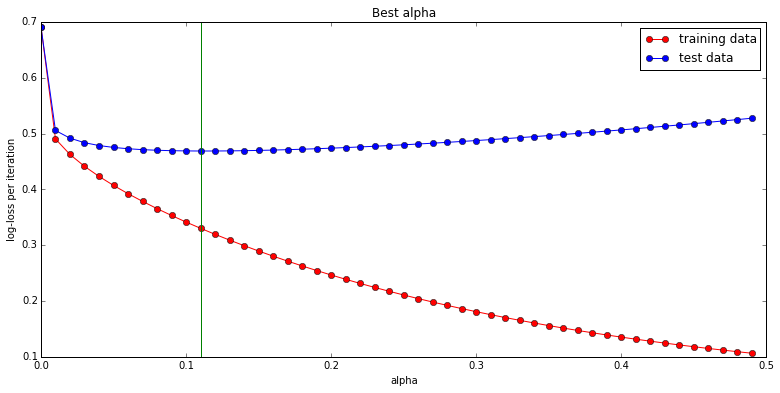

In [30]:
plt.figure(num=None, figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(arr_alpha, arr_log_loss_sgd_train_best_alpha, marker='o', color='r', label='training data')
plt.plot(arr_alpha, arr_log_loss_sgd_test_best_alpha, marker='o', color='b', label='test data')
plt.legend(loc="upper right")
plt.xlabel('alpha')
plt.ylabel('log-loss per iteration')
plt.title('Best alpha')

ndarr_test = np.array(arr_log_loss_sgd_test_best_alpha)
print((ndarr_test.argmin(), arr_alpha[ndarr_test.argmin()], arr_log_loss_sgd_test_best_alpha[ndarr_test.argmin()]))

plt.axvline(arr_alpha[ndarr_test.argmin()], color = 'g')

if(TEST_DATA == 'T'):
    plt.savefig('./images/best_param_sgd_T.png')
elif(TEST_DATA == 'C'):
    plt.savefig('./images/best_param_sgd_C.png')

###### ADF : variance

In [31]:
start_time = time.time()

if(TEST_DATA == 'T'):
    arr_var = list(np.linspace(.0001, 2., 50, endpoint=False))
    arr_log_loss_adf_train_best_var = [0]*len(arr_var)
    arr_log_loss_adf_test_best_var = [0]*len(arr_var)

    for i in range(0,len(arr_var)):
        param, arr_y, arr_p, arr_log_loss_adf_train_best_var[i], arr_log_loss_adf_test_best_var[i] = adf_training(variance = arr_var[i]
                 , D = 2**20
                 , f_debug = False
                 , f_step_validation = False
                 , f_validation = True
                 , c_ds = ds_best_param_titanic
                 , c_fi = fi_titanic)

        print('%s, i:%s, param:%s, log-loss(tr:%s, te:%s)' %(datetime.now(), i, arr_var[i]
                                                         , arr_log_loss_adf_train_best_var[i]
                                                         , arr_log_loss_adf_test_best_var[i]))

elif(TEST_DATA == 'C'):
    arr_var = list(np.linspace(.0001, .2, 50, endpoint=False))
    arr_log_loss_adf_train_best_var = [0]*len(arr_var)
    arr_log_loss_adf_test_best_var = [0]*len(arr_var)
    
    for i in range(0,len(arr_var)):
        param, arr_y, arr_p, arr_log_loss_adf_train_best_var[i], arr_log_loss_adf_test_best_var[i] = adf_training(variance = arr_var[i]
                 , D = 2**20
                 , f_debug = False
                 , f_step_validation = False
                 , f_validation = True
                 , c_ds = ds_best_param_criteo
                 , c_fi = fi_criteo)
        print('%s, i:%s, param:%s, log-loss(tr:%s, te:%s)' %(datetime.now(), i, arr_var[i]
                                                         , arr_log_loss_adf_train_best_var[i]
                                                         , arr_log_loss_adf_test_best_var[i]))
    
print("---Total execution time: %s seconds ---" % (time.time() - start_time))

2016-05-15 19:20:24.258864, i:0, param:0.0001, log-loss(tr:0.5637217661946521, te:0.5307532042866816)
2016-05-15 19:20:27.771373, i:1, param:0.004098, log-loss(tr:0.46689164684935613, te:0.48115927079326976)
2016-05-15 19:20:31.266933, i:2, param:0.008096, log-loss(tr:0.445533737645424, te:0.4747430327845542)
2016-05-15 19:20:34.740558, i:3, param:0.012094, log-loss(tr:0.4301030735201744, te:0.4721619233148739)
2016-05-15 19:20:38.226082, i:4, param:0.016092, log-loss(tr:0.4173842836044793, te:0.4709694139349793)
2016-05-15 19:20:41.699137, i:5, param:0.02009, log-loss(tr:0.40631207028069116, te:0.4704763098444929)
2016-05-15 19:20:45.188574, i:6, param:0.024088, log-loss(tr:0.39638550121913496, te:0.470400456729436)
2016-05-15 19:20:48.678943, i:7, param:0.028086, log-loss(tr:0.3873222840303443, te:0.47060058997511406)
2016-05-15 19:20:52.170037, i:8, param:0.032084, log-loss(tr:0.37894435757683514, te:0.4709962557435091)
2016-05-15 19:20:55.626155, i:9, param:0.036082, log-loss(tr:0.

(6, 0.024088000000000002, 0.470400456729436)


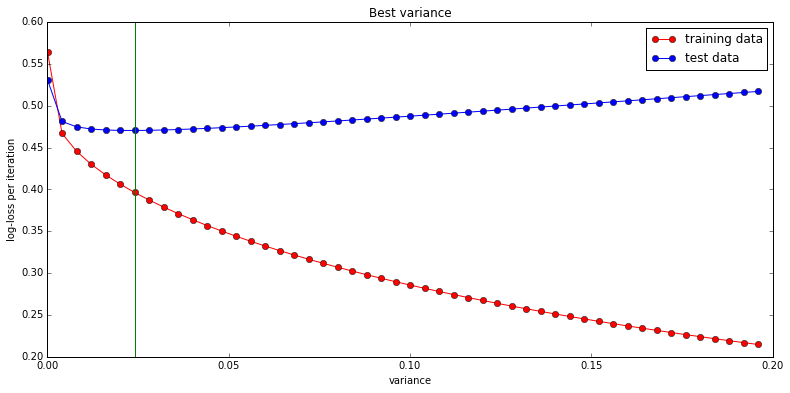

In [32]:
plt.figure(num=None, figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(arr_var, arr_log_loss_adf_train_best_var, marker='o', color= 'r', label='training data')
plt.plot(arr_var, arr_log_loss_adf_test_best_var, marker='o', color= 'b', label='test data')
plt.legend(loc="upper right")
plt.xlabel('variance')
plt.ylabel('log-loss per iteration')
plt.title('Best variance')

ndarr_test = np.array(arr_log_loss_adf_test_best_var)
print((ndarr_test.argmin(), arr_var[ndarr_test.argmin()], arr_log_loss_adf_test_best_var[ndarr_test.argmin()]))

plt.axvline(arr_var[ndarr_test.argmin()], color = 'g')

if(TEST_DATA == 'T'):
    plt.savefig('./images/best_param_adf_T.png')
elif(TEST_DATA == 'C'):
    plt.savefig('./images/best_param_adf_C.png')

# Tracing log-loss as the number of sample grows(step_validation)

In [54]:
ds_step_vali_titanic = DataSize(np.round(800/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 800        #train_start, train_size
                         , 801, 91)    #test_start, test_size

ds_step_vali_criteo = DataSize(np.round(1000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 1000        #train_start, train_size
                         , 1001, 100)    #test_start, test_size

ds_step_vali_criteo = DataSize(np.round(10000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 10000        #train_start, train_size
                         , 10001, 1000)    #test_start, test_size
ds_step_vali_criteo = DataSize(np.round(1000000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 10000000        #train_start, train_size
                         , 10000001, 100000)    #test_start, test_size

ds_step_vali_titanic.display()
ds_step_vali_criteo.display()

num_metric_check_point: 16.0
num_status_check_point: 1
num_train_data_start  : 1
num_train_data_end    : 800
num_train_data_size   : 800
num_test_data_start   : 801
num_test_data_end     : 891
num_test_data_size    : 91
num_metric_check_point: 20000.0
num_status_check_point: 1
num_train_data_start  : 1
num_train_data_end    : 10000000
num_train_data_size   : 10000000
num_test_data_start   : 10000001
num_test_data_end     : 10100000
num_test_data_size    : 100000


###### SGD 

In [55]:
start_time = time.time()

if(TEST_DATA == 'T'):
    alpha = 0.92000539999999997 # best for titanic
    arr_log_loss_sgd_test = sgd_training(alpha = alpha
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             , c_ds = ds_step_vali_titanic
                                             #, c_ds = ds_step_vali_criteo
                                             , c_fi = fi_titanic)
                                             #, c_fi = fi_criteo)
elif(TEST_DATA == 'C'):
    alpha = 0.100008 # best for criteo
    alpha = 0.11000779999999999
    arr_log_loss_sgd_test = sgd_training(alpha = alpha
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             #, c_ds = ds_step_vali_titanic
                                             , c_ds = ds_step_vali_criteo
                                             #, c_fi = fi_titanic)
                                             , c_fi = fi_criteo)
    
print("---Total execution time: %s seconds ---" % (time.time() - start_time))

---Total execution time: 81738.79210209846 seconds ---


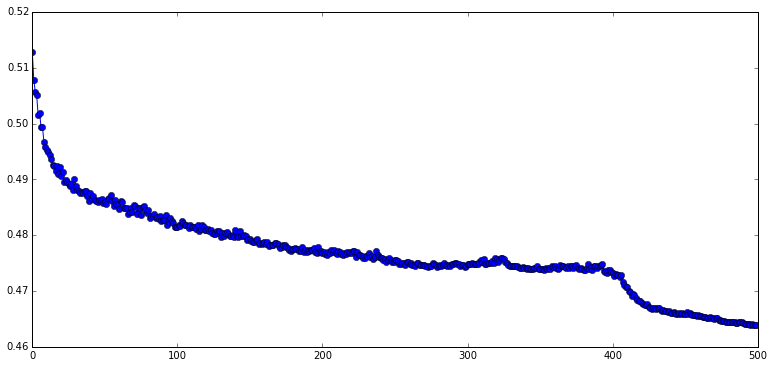

In [56]:
plot_log_loss(arr_log_loss_sgd_test)

ndarr_log_loss_sgd_test = np.array(arr_log_loss_sgd_test)
(ndarr_log_loss_sgd_test.argmin(), arr_log_loss_sgd_test[ndarr_log_loss_sgd_test.argmin()])


if(TEST_DATA == 'T'):
    plt.savefig('./images/step_vali_sgd_T.png')
elif(TEST_DATA == 'C'):
    plt.savefig('./images/step_vali_sgd_C.png')

###### ADF

In [36]:
start_time = time.time()

if(TEST_DATA == 'T'):
    init_v = 0.52007399999999993 # best for titanic
    arr_log_loss_adf_test = adf_training(variance = init_v
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             , c_ds = ds_step_vali_titanic
                                             #, c_ds = ds_step_vali_criteo
                                             , c_fi = fi_titanic)
                                             #, c_fi = fi_criteo)
elif(TEST_DATA == 'C'):
    init_v = 0.024088000000000002 # best for criteo
    arr_log_loss_adf_test = adf_training(variance = init_v
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = True
                                             , f_validation = False
                                             #, c_ds = ds_step_vali_titanic
                                             , c_ds = ds_step_vali_criteo
                                             #, c_fi = fi_titanic)
                                             , c_fi = fi_criteo)

print("---Total execution time: %s seconds ---" % (time.time() - start_time))


---Total execution time: 1596.8921689987183 seconds ---


In [1]:
plot_log_loss(arr_log_loss_adf_test)

ndarr_log_loss_adf_test = np.array(arr_log_loss_adf_test)
(ndarr_log_loss_adf_test.argmin(), arr_log_loss_adf_test[ndarr_log_loss_adf_test.argmin()])


if(TEST_DATA == 'T'):
    plt.savefig('./images/step_vali_adf_T.png')
elif(TEST_DATA == 'C'):
    plt.savefig('./images/step_vali_adf_C.png')

NameError: name 'plot_log_loss' is not defined

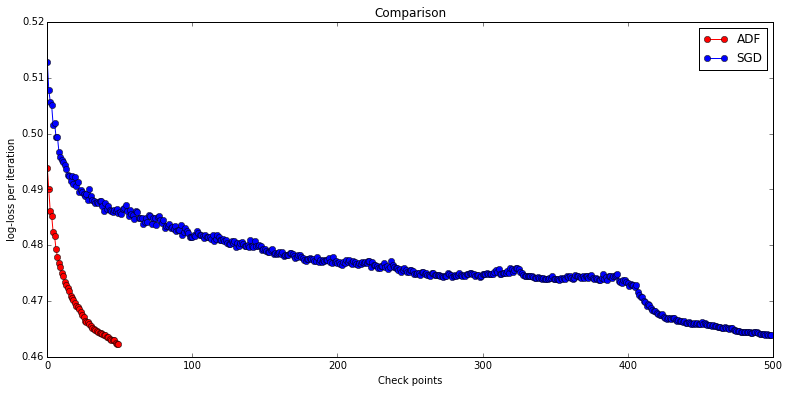

In [57]:
plt.figure(num=None, figsize=(13, 6), dpi=80, facecolor='w', edgecolor='k')

x1 = range(len(arr_log_loss_adf_test))
plt.plot(x1, arr_log_loss_adf_test, marker='o', color = 'r', label='ADF')
x2 = range(len(arr_log_loss_sgd_test))
plt.plot(x2, arr_log_loss_sgd_test, marker='o', color = 'b', label='SGD')
plt.legend(loc="upper right")
plt.xlabel('Check points')
plt.ylabel('log-loss per iteration')
plt.title('Comparison')


if(TEST_DATA == 'T'):
    plt.savefig('./images/step_vali_comparison_T.png')
elif(TEST_DATA == 'C'):
    plt.savefig('./images/step_vali_comparison_C.png')

# ?

In [49]:
ds_more_vali_titanic = DataSize(np.round(800/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 800        #train_start, train_size
                         , 801, 91)    #test_start, test_size

ds_more_vali_criteo = DataSize(np.round(1000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 1000        #train_start, train_size
                         , 1001, 100)    #test_start, test_size

ds_more_vali_criteo = DataSize(np.round(1000/50)      # num_metric_check_point
                         , 1      # num_status_check_point
                         , 1, 1000000        #train_start, train_size
                         , 1000001, 100000)    #test_start, test_size


###### SGD

In [50]:
start_time = time.time()


if(TEST_DATA == 'T'):
    alpha = 0.92000539999999997 # best for titanic
    param_w, arr_sgd_y, arr_sgd_p, log_loss_sgd_train, log_loss_sgd_test = sgd_training(alpha = alpha
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = False
                                             , f_validation = True
                                             , c_ds = ds_more_vali_titanic
                                             , c_fi = fi_titanic)
elif(TEST_DATA == 'C'):
    alpha = 0.100008 # best for criteo
    param_w, arr_sgd_y, arr_sgd_p, log_loss_sgd_train, log_loss_sgd_test = sgd_training(alpha = alpha
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = False
                                             , f_validation = True
                                             , c_ds = ds_more_vali_criteo
                                             , c_fi = fi_criteo)
    
print("---Total execution time: %s seconds ---" % (time.time() - start_time))


---Total execution time: 170.86889100074768 seconds ---


###### ADF

In [51]:



start_time = time.time()

if(TEST_DATA == 'T'):
    init_v = 0.52007399999999993 # best for titanic
    #init_v = 0.0052007399999999993 # best for titanic
    param_theta, arr_adf_y, arr_adf_p, log_loss_adf_train, log_loss_adf_test = adf_training(variance = init_v
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = False
                                             , f_validation = True
                                             , c_ds = ds_more_vali_titanic
                                             , c_fi = fi_titanic)
elif(TEST_DATA == 'C'):
    init_v = 0.024088000000000002 # best for criteo
    param_theta, arr_adf_y, arr_adf_p, log_loss_adf_train, log_loss_adf_test = adf_training(variance = init_v
                                             , D = 2**20
                                             , f_debug = False
                                             , f_step_validation = False
                                             , f_validation = True
                                             , c_ds = ds_more_vali_criteo
                                             , c_fi = fi_criteo)


print("---Total execution time: %s seconds ---" % (time.time() - start_time))


---Total execution time: 276.404109954834 seconds ---


###### Comparison

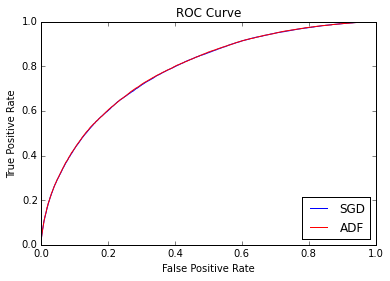

In [52]:
#fpr_sgd = dict()
#tpr_sgd = dict()
#roc_auc_sgd = dict()

fpr_sgd, tpr_sgd, _ = roc_curve(arr_sgd_y, arr_sgd_p)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd) #auc

fpr_adf, tpr_adf, _ = roc_curve(arr_adf_y, arr_adf_p)
roc_auc_adf = auc(fpr_adf, tpr_adf) #auc

plt.figure()
plt.plot(fpr_sgd, tpr_sgd, label='SGD', color='b')
plt.plot(fpr_adf, tpr_adf, label='ADF', color='r')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
#plt.show() # or use command %matplotlib inline

if(TEST_DATA == 'T'):
    plt.savefig('./images/step_vali_roc_T.png')
elif(TEST_DATA == 'C'):
    plt.savefig('./images/step_vali_roc_C.png')

In [53]:
(roc_auc_sgd, roc_auc_adf)

(0.78110714529429526, 0.78198942683050354)